Import dependencies:

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from scipy.spatial.transform import Rotation as R
#from mpl_toolkits.mplot3d import axes3d

In [2]:
%matplotlib widget

Load a point cloud from a .txt file:

In [3]:
def pc_from_txt(filename):
    """
    Loads a point cloud from a .txt file
    
    Parameters:
    filename:string - location for the .txt file
    
    Returns:
    point_cloud - nx3 numpy array of point cloud data
    """
    point_cloud = np.loadtxt(filename)
    return point_cloud

Plot a point cloud with matplotlib. Random downsampling to make the plot load faster:

In [4]:
def plot_downsample(point_cloud, sample_fraction = 0.1, random_seed=0, figsize=(10,10), is_scaled = True):
    """
    Plots a 3D point cloud using matplotlib
    
    Parameters:
    point_cloud - nx3 numpy array of the points to plot
    sample_fraction - downsampling fraction (float)
    random_seed - rng seed
    figsize - self explanatory (tuple)
    
    Returns:
    figure, axes for the plot
    """
    np.random.seed(random_seed)

    idx = np.random.randint(point_cloud.shape[0], size=int(point_cloud.shape[0]*sample_fraction))
    
    plot_points = point_cloud[idx,:]
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    if is_scaled:
        ax.set_xlim((-1,1))
        ax.set_ylim((-1,1))
        ax.set_zlim((-1,1))
    
    ax.scatter(plot_points[:,0], plot_points[:,1], plot_points[:,2], marker='.')
    
    return fig, ax

Rescale and center the point clouds:

In [5]:
def center_and_scale(point_cloud):
    """
    Recenters a point cloud to the origin and
    scales to [-1,1]^3
    
    Parameters:
    point_cloud - nx3 numpy array of points
    
    Returns
    scaled_cloud - centered and scaled point cloud
    """
    centered_cloud = point_cloud-np.mean(point_cloud, axis=0)
    return centered_cloud/np.max(centered_cloud)

In [109]:
point_cloud = pc_from_txt('../data/treesXYZ/alt01_21.txt')

In [110]:
scaled_cloud = center_and_scale(point_cloud)

In [111]:
%matplotlib widget
fig, ax = plot_downsample(scaled_cloud, sample_fraction=0.1, figsize = (5,5))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Perspective depth projection:

In [112]:
def project_point(point, camera_projection, f=1):
    """
    Perspective projection of a single point on to image plane.
    
    Parameters:
    point - 3D point to be projected as numpy array, in real world coordinates - Dimension 4 NOT 1x4 
    camera_projection - 4x4 camera projection matrix as numpy array:
                        x_camera_tilde = camera_projection * x_world_tilde (with x as col. vectors)
                        camera_transform = r11 r12 r13 Tx
                                           r21 r22 r23 Ty
                                           r31 r32 r33 Tz 
                                           0   0   0   1
                                           
    f - distance from camera to image plane. Default=1

    Returns
    projected_point - projected coordinates in image plane - real world coordinates
    depth - depth of projected point (from camera)
    
    _tilde denotes homegeneous coordinates
    """ 
    
    x_world_tilde = np.append(point, 1)
    
    #x_world_tilde = np.array([x_world_tilde]).transpose()
    x_camera_tilde = np.matmul(camera_projection, x_world_tilde)
    

    
    perspective_projection = np.array([
                            [f, 0, 0, 0],
                            [0, f, 0, 0],
                            [0, 0, 1, 0],
                            ])
    
    x_image_tilde = np.matmul(perspective_projection, x_camera_tilde)
    
    #print(x_image_tilde)
    
    x_image = np.array([x_image_tilde[0]/x_image_tilde[2], x_image_tilde[1]/x_image_tilde[2]])
    
    return x_image, x_camera_tilde[2]

def project_points(points, camera_projection, f=1):
    """
    Projects a list/numpy array of points in one go
    """
    projected_points_depths = [project_point(point, camera_projection, f) for point in points]
    projected_points = np.array([x[0] for x in projected_points_depths])
    projected_depths = np.array([x[1] for x in projected_points_depths])
    
    return projected_points, projected_depths

def get_rotation_matrix(a, b):
    """
    Gets rotation matrix to rotate vector a onto vector b
    """
    a = np.array([a/np.linalg.norm(a)]).transpose()
    b = np.array([b/np.linalg.norm(b)]).transpose()

    #Rodriguez rotation formula - rotate abt k = (a+b)/2 by pi
    ab = a + b
    R = 2*np.matmul(ab, ab.transpose())/np.matmul(ab.transpose(), ab) - np.eye(3)
    
    return R
    

def get_camera_projection(camera_position, camera_z_direction, camera_x_direction):
    """
    Gets the camera projection matrix from the position and orientation of the camera
    
    Parameters:
    camera_position - self explanatory (length 3 vector)
    camera_z_direction - optical axis of the camera (length 3 vector)
    
    Note - this deals really badly with 180 degree rotations so I've basically abandoned it.
    """
    assert np.dot(camera_z_direction, camera_x_direction) == 0
    
    camera_z_direction = np.array(camera_z_direction)
    camera_z_direction = camera_z_direction/np.linalg.norm(camera_z_direction)
    
    camera_x_direction = np.array(camera_x_direction)
    camera_x_direction = camera_x_direction/np.linalg.norm(camera_x_direction)
    
    T = np.array(np.array([camera_position])).transpose()
    s = np.array([[0,0,0,1]])

    a = np.array([0, 0, 1])
    R1 = get_rotation_matrix(a, camera_z_direction)
    
    new_x_dir = np.matmul(R1, np.array([1,0,0]))
    R2 = get_rotation_matrix(new_x_dir, camera_x_direction)
    
    R = np.matmul(R2, R1)
    
    #Stack R,T, s into camera projection matrix
    print(T.shape)
    pr = np.hstack((R,T))

    pr = np.vstack((pr, s))
    
    return pr
    

def depth_image_from_projection(points, depths, camera_fov_deg=90, image_dim=128):
    """
    Plots a depth image from perspective projected points
    
    Parameters:
    points - nx2 numpy array of projected points
    depths - corresponding point depths from camera
    camera_fov_deg - camera FOV in degrees
    """
    
    #The maximum projected image coordinate based on camera FOV
    max_value = np.tan(np.radians(camera_fov_deg/2))
    print(max_value)
    
    points = points + max_value #Change range from -max->max to 0->2*max
    pixel_coords = [ [round(x[0]/(2*max_value) * image_dim), round(x[1]/(2*max_value) * image_dim)] for x in points]
    
    image = np.zeros(shape=(image_dim, image_dim))
    
    for coord, depth in zip(pixel_coords, depths):
        i, j = coord[1], coord[0]
        if (0 <= i < image_dim) and (0 <= j < image_dim): #If not outside the FOV
            if not(image[i, j]):
                image[i, j] = depth
            elif depth < image[i, j]: #If there's something else there
                image[i, j] = depth
                    
    #min_val = np.min(image)                
    #print(min_val)                
        
    #image[np.isclose(image, 0, atol=1e-15)==True] = min_val
    
    return image

def plot_depth_image(depth_image):
    fig, ax = plot.subplots(figsize=(5,5))

In [113]:
camera_projection = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 1.4],
    [0, 0, 0, 1]
])

proj_points, depths = project_points(scaled_cloud, camera_projection)
project_point([1,0,1], camera_projection)

(array([0.71428571, 0.71428571]), 1.4)

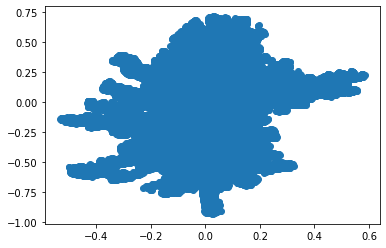

In [114]:
%matplotlib inline
figScatter, axScatter = plt.subplots()
axScatter.scatter(proj_points[:,0], proj_points[:,1])

0.9999999999999999


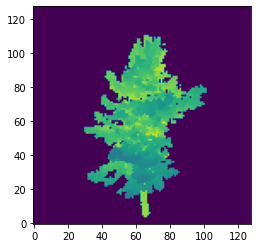

In [115]:
%matplotlib inline
img = depth_image_from_projection(proj_points, depths, camera_fov_deg = 90)
depthimg = plt.imshow(img, origin='lower')

In [116]:
##Camera projections - all checked on alt_01_18.txt

#Front to back
camera_projection = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 1.4],
    [0, 0, 0, 1]
])

#Back to front
camera_projection = np.array([
    [-1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, -1, 0, 1.4],
    [0, 0, 0, 1]
])

#Bottom up
camera_projection = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 1.4],
    [0, 0, 0, 1]
])

#Top down
camera_projection = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, -1, 1.4],
    [0, 0, 0, 1]
])

#Left to right
camera_projection = np.array([
    [0, -1, 0, 0],
    [0, 0, 1, 0],
    [1, 0, 0, 1.4],
    [0, 0, 0, 1]
])

#Right to left
camera_projection = np.array([
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [-1, 0, 0, 1.4],
    [0, 0, 0, 1]
])